In [22]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.base import BaseEstimator
from sklearn.preprocessing import Binarizer
from sklearn.linear_model import LogisticRegression
import Titanic_preprocessing
import pandas as pd
import numpy as np


# from PIL import Image

In [2]:
class MyDummyClassifier(BaseEstimator):
    def fit(self, x, y=None):
        pass

    def predict(self, x):
        pred = np.zeros((x.shape[0], 1))
        for i in range(x.shape[0]):
            if x['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
            # pred[i] = 0 if x['Sex'].iloc[i] == 1 else 1
        return pred


In [15]:
df = pd.read_csv('./kaggle/titanic/train.csv')
df = Titanic_preprocessing.preprocessing(df)
X = df[df.columns.difference(['Survived'])]
Y = df[['Survived']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=11)


myclf = MyDummyClassifier()
myclf.fit(X_train, Y_train)
pred = myclf.predict(X_test)
accuracy_score(Y_test, pred)

0.8324022346368715

In [4]:
class MyFakeClassifier(BaseEstimator):
    def fit(self, x, y=None):
        pass

    def predict(self, x):
        # return np.zeros((x.shape[0], 1), dtype=bool)
        return np.zeros((len(x), 1), dtype=bool)


In [11]:
# mnist digit

digits = load_digits()
# b = digits.data[5,:].reshape(8, 8) * 255 / np.max(digits.data[0,:].reshape(8, 8))
# image=Image.fromarray(b)
# image.show()

Y = (digits.target == 7).astype(int)
X_train, X_test, Y_train, Y_test = train_test_split(digits.data, Y, random_state=11)

print('shape: {}'.format(Y_test.shape))
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(Y_test).value_counts())


fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, Y_train)
pred = fakeclf.predict(X_test)
print('모든 예측 0, acc: {}'.format(accuracy_score(Y_test, pred)))



shape: (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측 0, acc: 0.9


In [14]:
def get_clf_eval(Y_test, pred):
    confusion = confusion_matrix(Y_test, pred)
    acc = accuracy_score(Y_test, pred)
    precision = precision_score(Y_test, pred)
    recall = recall_score(Y_test, pred)
    print('Confusion matrix')
    print(confusion)
    print('acc: {:.4f}, precision: {:.4f}, recall: {:.4f}'.format(acc, precision, recall))

In [23]:
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, Y_train.values.reshape(-1, ))
pred = lr_clf.predict(X_test)
get_clf_eval(Y_test, pred)

Confusion matrix
[[108  10]
 [ 14  47]]
acc: 0.8659, precision: 0.8246, recall: 0.7705


In [51]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print(pred_proba.shape)
print(pred_proba[:3])
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1, 1)], axis=1)
print(pred_proba_result[:3])

(179, 2)
[[0.44935225 0.55064775]
 [0.86335511 0.13664489]
 [0.86429643 0.13570357]]
[[0.44935225 0.55064775 1.        ]
 [0.86335511 0.13664489 0.        ]
 [0.86429643 0.13570357 0.        ]]


In [44]:
X = [
    [1, -1, 2],
    [2, 0, 0],
    [0, 1.1, 1.2]
]
binarizer = Binarizer(threshold=1.1) # 1.1 초과 1, 이하면 0
binarizer.fit_transform(X)

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [45]:
custom_threshold = 0.5
pred_proba_1 = lr_clf.predict_proba(X_test)[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold=custom_threshold)
custom_predict = binarizer.fit_transform(pred_proba_1)
get_clf_eval(Y_test, custom_predict)

Confusion matrix
[[108  10]
 [ 14  47]]
acc: 0.8659, precision: 0.8246, recall: 0.7705


In [46]:
custom_threshold = 0.4
pred_proba_1 = lr_clf.predict_proba(X_test)[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold=custom_threshold)
custom_predict = binarizer.fit_transform(pred_proba_1)
get_clf_eval(Y_test, custom_predict)      # 임계치를 낮추면 재현율(recall)이 올라간다

Confusion matrix
[[97 21]
 [11 50]]
acc: 0.8212, precision: 0.7042, recall: 0.8197


In [47]:
custom_threshold = 0.6
pred_proba_1 = lr_clf.predict_proba(X_test)[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold=custom_threshold)
custom_predict = binarizer.fit_transform(pred_proba_1)
get_clf_eval(Y_test, custom_predict)     # 임계치를 높이면 정밀도(precision)이 올라간다

Confusion matrix
[[113   5]
 [ 17  44]]
acc: 0.8771, precision: 0.8980, recall: 0.7213


In [52]:
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]

def get_eval_by_threshold(Y_test, pred, thresholds):
    for i in thresholds:
        binarizer = Binarizer(threshold=i)
        custom_predict = binarizer.fit_transform(pred)
        print('threshold: {}'.format(i))
        get_clf_eval(Y_test, custom_predict)
        print()

get_eval_by_threshold(Y_test, pred_proba_1, thresholds)

threshold: 0.4
Confusion matrix
[[97 21]
 [11 50]]
acc: 0.8212, precision: 0.7042, recall: 0.8197

threshold: 0.45
Confusion matrix
[[105  13]
 [ 13  48]]
acc: 0.8547, precision: 0.7869, recall: 0.7869

threshold: 0.5
Confusion matrix
[[108  10]
 [ 14  47]]
acc: 0.8659, precision: 0.8246, recall: 0.7705

threshold: 0.55
Confusion matrix
[[111   7]
 [ 16  45]]
acc: 0.8715, precision: 0.8654, recall: 0.7377

threshold: 0.6
Confusion matrix
[[113   5]
 [ 17  44]]
acc: 0.8771, precision: 0.8980, recall: 0.7213



반환된 분류 결정 임곗값 배열의 Shape: (165,)
반환된 precisions 배열의 Shape: (166,)
반환된 recalls 배열의 Shape: (166,)
thresholds 5 sample: [0.01974988 0.06956416 0.0840281  0.08474207 0.08920162]
precisions 5 sample: [0.34078212 0.34269663 0.34463277 0.34659091 0.34857143]
recalls 5 sample: [1. 1. 1. 1. 1.]
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135 150]
샘플용 10개의 임곗값:  [0.02 0.11 0.13 0.14 0.16 0.24 0.32 0.45 0.62 0.73 0.87]
샘플 임계값별 정밀도:  [0.341 0.372 0.401 0.44  0.505 0.598 0.688 0.774 0.915 0.968 0.938]
샘플 임계값별 재현율:  [1.    1.    0.967 0.902 0.902 0.902 0.869 0.787 0.705 0.492 0.246]


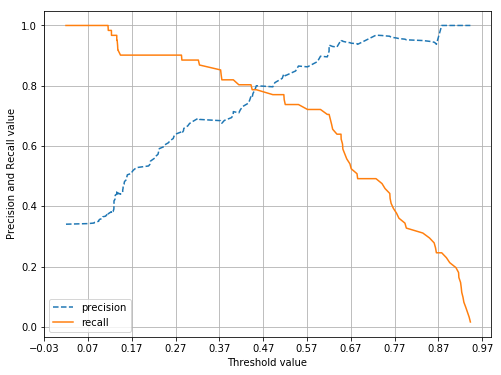

In [54]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일때의 예측 확률을 추출 
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1] 

# 실제값 데이터 셋과 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력 
precisions, recalls, thresholds = precision_recall_curve(Y_test, pred_proba_class1 )
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)
print('반환된 precisions 배열의 Shape:', precisions.shape)
print('반환된 recalls 배열의 Shape:', recalls.shape)

print("thresholds 5 sample:", thresholds[:5])
print("precisions 5 sample:", precisions[:5])
print("recalls 5 sample:", recalls[:5])

#반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 Step으로 추출. 
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index], 2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값 
print('샘플 임계값별 정밀도: ', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율: ', np.round(recalls[thr_index], 3))

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(Y_test, lr_clf.predict_proba(X_test)[:, 1] )
